In [10]:
#Import required packages
import ee
import pandas as pd
import numpy as np
import geopandas as gpd
from functools import reduce
from matplotlib import pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import *
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from tqdm import tqdm
from collections import Counter
import seaborn as sns

In [16]:
my_cloud_project = 'ee-YourProject' # your GEE cloud project ID
ee.Authenticate() 
ee.Initialize(project=my_cloud_project) # your GEE cloud project

my_scale = 1000
my_state_abbrv = 'MN'

In [17]:
my_pred_data = ee.Image('projects/' + my_cloud_project + '/assets/your_predictors').select(all_params)
states = ee.FeatureCollection("TIGER/2018/States")
geo = states.filter(ee.Filter.eq("STUSPS", my_state_abbrv)).geometry()

in_situ = ['Phosphorus', 'Nitrogen', 'Turbidity', 'Salinity', 'Chlorophyl_a', 'Ca', 'DO', 'pH', 'Water_Temp']
rsd_env = ['Heat_Insolation', 'Topo_Diversity', 'Precip_Winter', 'Precip_Summer', 'Flashiness', 
       'NDTI', 'NDSI', 'NDBI', 'NDVI',  'LST_Summer','LST_Winter', 'GPP_annual', 'GPP_Summer','gHM','Pressure_Duration', 'Freeze_Up', 
        'Spawn_Start', 'Spawn_End', 'Homerange_Similarity']

prop = ['Boater_Visitation', 'Water_Alteration', 'Public_Launches', 'Distance_to_Source']
comp = ['alpha_Native_Fish', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusk', 'Inv_Plants',
       'alpha_CAT', 'alpha_CENT', 'alpha_DAR', 'alpha_ESX', 'alpha_OTM', 'alpha_PRCH', 'alpha_SAL', 
       'alpha_SCUL', 'alpha_SUCK']
rsd_w_in_situ = rsd_env + in_situ
rsd_w_prop = rsd_env + prop
rsd_w_comp = rsd_env + comp
all = rsd_env + in_situ + prop + comp
rsd_w_comp_data = my_pred_data.select(rsd_w_comp).clip(geo)
rsd_env_data = my_pred_data.select(rsd_env).clip(geo)
rsd_w_in_situ_data = my_pred_data.select(rsd_w_in_situ).clip(geo)
rsd_w_prop_data = my_pred_data.select(rsd_w_prop).clip(geo)

all_data = my_pred_data.select(all).clip(geo)

pos_fc = ee.FeatureCollection('projects/' + my_cloud_project + '/assets/your_pos_data').filterBounds(geo)
bg_fc = ee.FeatureCollection('projects/' + my_cloud_project + '/assets/your_bg_data').filterBounds(geo)

In [34]:
def drop_col(model, X_train, y_train, random_state = 42):
    #Clone the model
    model_clone = clone(model)
    #Reset random state
    model_clone.random_state = random_state
    #Train and score the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    #Store importances
    importances = []
    
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col,axis=1),y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
        
    importances_df = make_imp_df(X_train.columns, importances)
    return importances_df        
        
# -------------------------------
# EE helpers
# -------------------------------

def compute_tss(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity + specificity - 1

def sample_rasters(dataset, pos_fc, bg_fc, scale=30):
    """
    Sample raster predictor values at all presence and background locations once.
    """
    def reduce_to_df(points_fc):
        fc = dataset.reduceRegions(
            collection=points_fc,
            reducer=ee.Reducer.mean(),
            scale=scale,
            crs='EPSG:4326',
            tileScale=16
        )
        df = ee.data.computeFeatures({'expression': fc, 'fileFormat': 'PANDAS_DATAFRAME'})
        df_clean = df.drop(columns=['geo','dow','year'], errors='ignore').dropna().astype(float)
        return df_clean

    pos_df = reduce_to_df(pos_fc)
    bg_df = reduce_to_df(bg_fc)
    return pos_df, bg_df

# -------------------------------
# Dataset tester with Python-side splits
# -------------------------------

def dataset_tester(dataset, pos_df, bg_df, seed=42, min_features_rfe=3):
    """
    Train models, compute metrics, and feature importance for one replicate
    using pre-sampled raster values.
    """
    # --- Add random numbers for train/test split ---
    np.random.seed(seed)
    pos_df = pos_df.copy()
    bg_df = bg_df.copy()
    pos_df['random'] = np.random.rand(len(pos_df))
    bg_df['random'] = np.random.rand(len(bg_df))

    # --- Split train/test ---
    train_pos = pos_df[pos_df['random'] <= 0.75]
    test_pos = pos_df[pos_df['random'] > 0.75]
    train_bg = bg_df[bg_df['random'] <= 0.50]
    test_bg = bg_df[bg_df['random'] > 0.85]

    X_train = pd.concat([train_pos.drop(columns=['Present','random']),
                         train_bg.drop(columns=['Present','random'])])
    y_train = pd.concat([train_pos['Present'], train_bg['Present']])
    X_test = pd.concat([test_pos.drop(columns=['Present','random']),
                        test_bg.drop(columns=['Present','random'])])
    y_test = pd.concat([test_pos['Present'], test_bg['Present']])

    # --- Standardize ---
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # --- Base models ---
    dt = DecisionTreeClassifier(max_depth=5)
    MaxEnt = LogisticRegression(max_iter=5000)
    rf = RandomForestClassifier(n_estimators=100)
    brt = GradientBoostingClassifier(n_estimators=100)
    mlp = MLPClassifier(max_iter=2000)

    base_models = {'DT': dt, 'MaxEnt': MaxEnt, 'RF': rf, 'BRT': brt, 'MLP': mlp}
    importance_models = {'DT': dt, 'MaxEnt': MaxEnt, 'RF': rf, 'BRT': brt}  # exclude MLP

    # Train all models
    for model in base_models.values():
        model.fit(X_train_scaled, y_train)

    # Voting classifier
    vc_names = [(k, v) for k, v in base_models.items()]
    vc = VotingClassifier(estimators=vc_names, voting='soft', weights=[1.0]*len(vc_names))
    vc.fit(X_train_scaled, y_train)

    # --- Metrics ---
    y_pred = vc.predict(X_test_scaled)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'tss': compute_tss(y_test, y_pred)
    }

    # --- Feature importance ---
    rfe_dict, perm_dict, drop_dict = {}, {}, {}
    for alg_name, clf in importance_models.items():
        # RFE
        rfe_selector = RFECV(estimator=clf, min_features_to_select=min_features_rfe, step=1, verbose=0)
        rfe_selector.fit(X_train_scaled, y_train)
        rfe_dict[alg_name] = X_train_scaled.columns[rfe_selector.get_support()].tolist()

        # Permutation
        perm_imp = permutation_importance(clf, X_train_scaled, y_train, n_repeats=3, random_state=seed)
        perm_dict[alg_name] = pd.Series(perm_imp.importances_mean, index=X_train_scaled.columns)\
                               .sort_values(ascending=False).index[:3].tolist()

        # Drop-column importance (assumes drop_col function exists)
        drop_col_feats = drop_col(clf, X_train_scaled, y_train)
        drop_dict[alg_name] = drop_col_feats.sort_values('feature_importance', ascending=False)['feature'][:3].tolist()

    return {
        'vc': vc,
        'base_models': base_models,
        'metrics': metrics,
        'importance': {
            'rfe': rfe_dict,
            'permutation': perm_dict,
            'drop': drop_dict
        },
        'X_train_scaled': X_train_scaled,
        'y_train': y_train
    }

# -------------------------------
# Parallel runner with pre-sampled data
# -------------------------------

def run_all_datasets_parallel(datasets, dataset_names, pos_fc, bg_fc, n_replicates=3, n_jobs=-1, scale=30):
    """
    Run multiple datasets and replicates in parallel, sampling rasters only once.
    """
    all_results = {}

    for dataset, name in tqdm(zip(datasets, dataset_names), total=len(datasets), desc="Datasets"):
        # Sample once
        pos_df, bg_df = sample_rasters(dataset, pos_fc, bg_fc, scale=scale)

        # Run replicates in parallel
        if n_jobs == 1:
            results = [dataset_tester(dataset, pos_df, bg_df, seed=42+i) for i in range(n_replicates)]
        else:
            results = Parallel(n_jobs=n_jobs)(
                delayed(dataset_tester)(dataset, pos_df, bg_df, seed=42+i) for i in range(n_replicates)
            )

        all_results[name] = results

    return all_results


In [35]:
datasets =  [rsd_env_data, rsd_w_in_situ, rsd_w_comp_data, rsd_w_prop_data, all_data]
dataset_names =  ['RSD', 'RSD_w_Chem', 'RSD_w_Comp', 'RSD_w_Prop', 'All_Data']
n_replicates = 2

all_results = run_all_datasets_parallel(
    datasets=datasets,
    dataset_names=dataset_names,
    pos_fc=pos_fc,
    bg_fc=bg_fc,
    n_replicates=n_replicates,
    n_jobs=-1
)

Datasets: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [44:46<00:00, 895.53s/it]


C:\Users\leif.howard\AppData\Local\Temp\ipykernel_18788\3083522489.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tss_df, x='Dataset', y='TSS', palette='Set2')


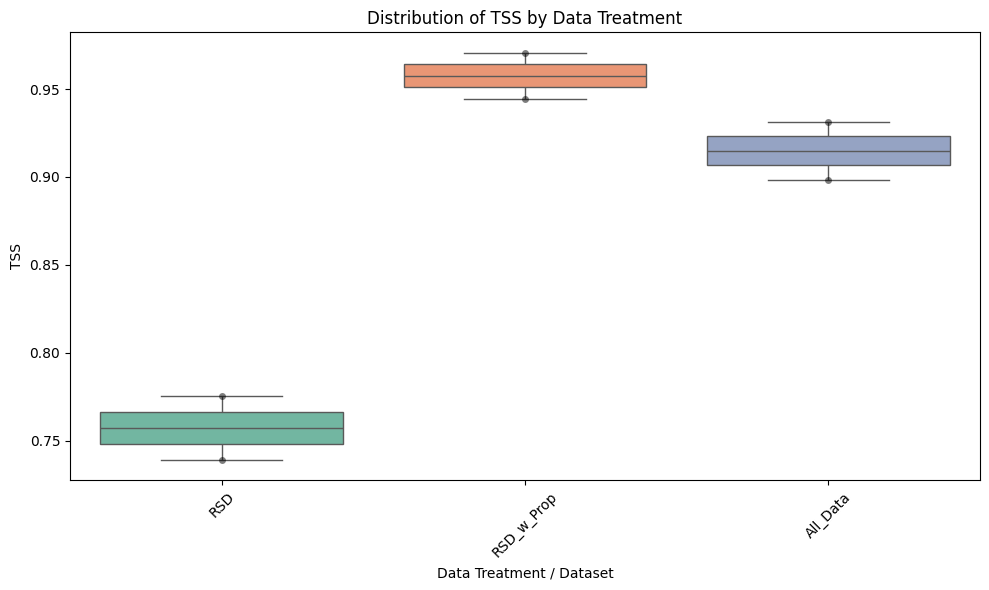

In [36]:
# --- Convert results to a tidy DataFrame ---
rows = []
for dataset_name, replicates in all_results.items():
    for rep in replicates:
        tss = rep['metrics']['tss']
        rows.append({'Dataset': dataset_name, 'TSS': tss})

tss_df = pd.DataFrame(rows)

# --- Plot distributions by dataset / treatment ---
plt.figure(figsize=(10,6))
sns.boxplot(data=tss_df, x='Dataset', y='TSS', palette='Set2')
sns.swarmplot(data=tss_df, x='Dataset', y='TSS', color='k', alpha=0.5)
plt.title('Distribution of TSS by Data Treatment')
plt.ylabel('TSS')
plt.xlabel('Data Treatment / Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
def aggregate_feature_importances(all_results, importance_types=['rfe', 'permutation', 'drop']):
    """
    Aggregate feature importance counts across multiple replicates and importance types.
    
    Parameters
    ----------
    all_results : dict
        Output from run_all_datasets_parallel
    importance_types : list
        Which importance methods to include in aggregation
    
    Returns
    -------
    aggregated_counts : dict
        Dictionary {dataset_name: Counter(feature: total_count)}
    """
    aggregated_counts = {}
    
    for dataset_name, replicates in all_results.items():
        counter = Counter()
        for rep in replicates:
            for method in importance_types:
                method_dict = rep['importance'][method]
                for alg_name, feats in method_dict.items():
                    counter.update(feats)  # count each feature occurrence
        aggregated_counts[dataset_name] = counter
        
    return aggregated_counts

def plot_feature_importances(aggregated_counts, top_n=10):
    """
    Plot aggregated feature importance counts for each dataset.
    """
    for dataset_name, counter in aggregated_counts.items():
        # Get top N features
        most_common = counter.most_common(top_n)
        features, counts = zip(*most_common)
        
        fig, ax = plt.subplots(figsize=(10,5))
        ax.bar(features, counts)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
        ax.set_title(f"Top {top_n} Feature Importances: {dataset_name}")
        ax.set_ylabel("Total count in top 3 across methods & replicates")
        plt.tight_layout()
        plt.show()


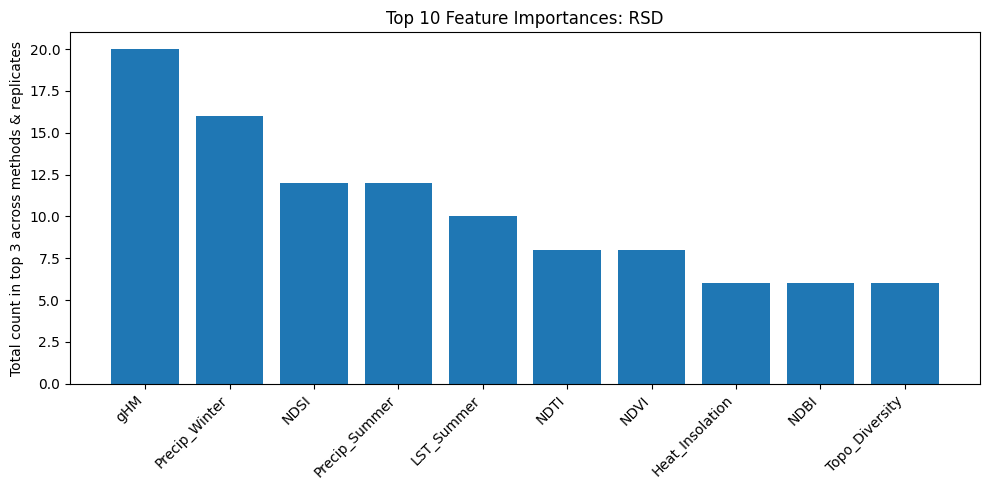

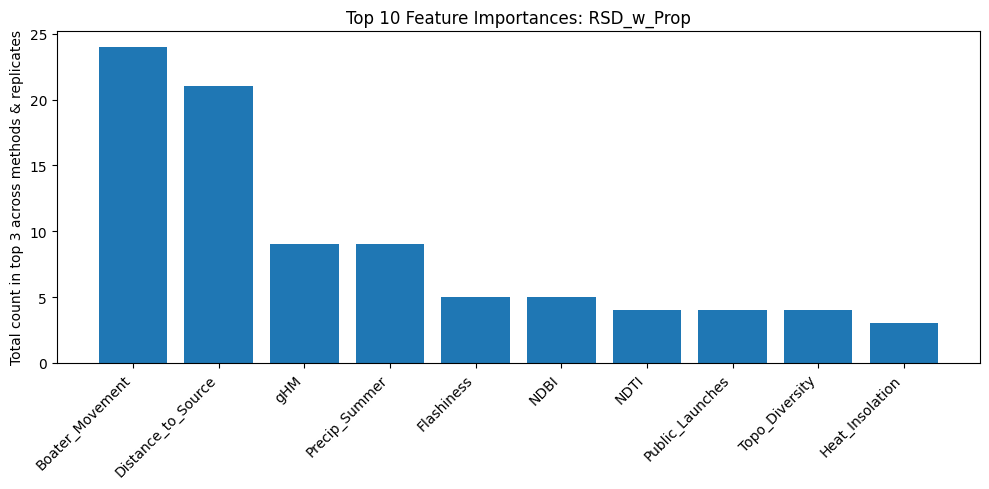

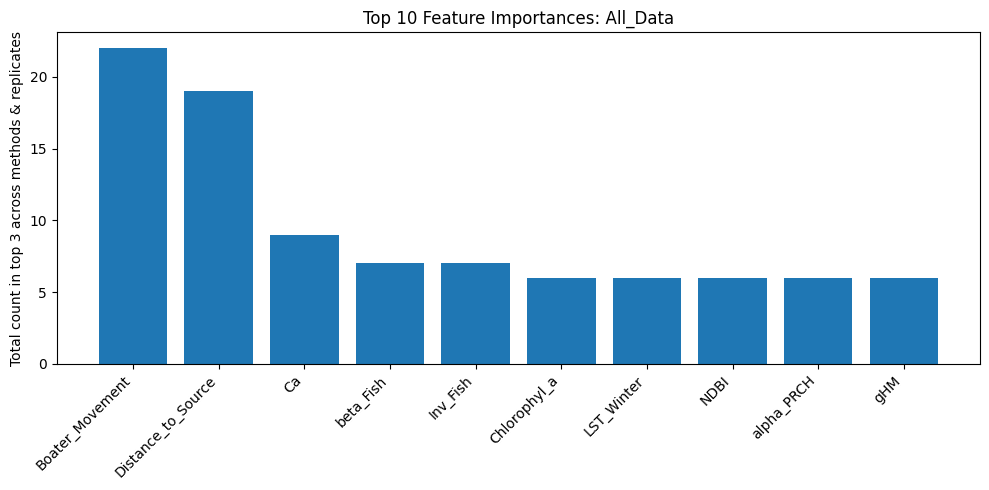

In [38]:
# Aggregate
aggregated_counts = aggregate_feature_importances(all_results)

# Plot top 10 features for each dataset
plot_feature_importances(aggregated_counts, top_n=10)
